In [50]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq

Le but est de simuler avec différentes méthodes le hamiltonien suivant : 

$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger + \hat{a}) \right)$$

## Résolution SCQUBITS

In [51]:
def get_eigen_sc(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    omega = np.sqrt(8 * EC_R * EL_R)

    n_zpf = (EL_R / (32 * EC_R))**0.25

    transmon = scq.Transmon(EJ=EJ, EC=EC_T, ng=0.0, ncut=n_cut)

    oscillator = scq.Oscillator(E_osc=omega, truncated_dim=osc_cut)

    hilbert_space = scq.HilbertSpace([transmon, oscillator])

    n_T = transmon.n_operator()

    a = oscillator.annihilation_operator()
    adag = oscillator.creation_operator()

    n_R = n_zpf * 1j * (adag - a)

    hilbert_space.add_interaction(
        g=-4 * E_coupling, op1=(transmon.n_operator, transmon), op2=(n_R, oscillator)
    )


    vals = hilbert_space.eigenvals(evals_count=N_eigen + 1)
    vals = vals - vals[0]

    return vals[1:]

## Résolution qutip

In [52]:
def Hamiltonian_qutip(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
):
    omega = np.sqrt(8 * EC_R * EL_R)
    n_zpf = (EL_R / (32*EC_R))**0.25

    dim = 2 * n_cut + 1
    n_list = np.arange(-n_cut, n_cut + 1)
    n_op = qt.Qobj(np.diag(n_list))

    op_couple = qt.tunneling(dim, 1)

    H_T = 4 * EC_T * n_op**2 - 0.5 * EJ * op_couple

    a = qt.destroy(osc_cut)
    H_R = omega * a.dag() * a
    n_R = n_zpf * 1j * (a.dag() - a)

    I_T = qt.qeye(dim)
    I_R = qt.qeye(osc_cut)

    return (
        qt.tensor(H_T, I_R)
        + qt.tensor(I_T, H_R)
        - 4 * E_coupling * qt.tensor(n_op, n_R)
    )

In [53]:
def get_eigen_qutip(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    Hamiltonian = Hamiltonian_qutip(EJ, EC_T, EC_R, EL_R, E_coupling, n_cut, osc_cut)
    evals = Hamiltonian.eigenenergies()
    vals = evals - evals[0]

    return vals[1 : N_eigen + 1]

## Résolution numpy

In [54]:
def Hamiltonian_numpy(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
):
    diag = [4 * EC_T * i**2 for i in range(-n_cut, n_cut + 1)]
    diag_off = [-EJ / 2 for i in range(-n_cut, n_cut)]
    diag_on = [-EJ / 2 for i in range(-n_cut, n_cut)]
    H_T = np.diag(diag, k=0) + np.diag(diag_on, k=1) + np.diag(diag_off, k=-1)
    I_T = np.eye(2 * n_cut + 1)

    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25
    a = np.zeros((osc_cut, osc_cut))
    for i in range(osc_cut - 1):
        a[i][i + 1] = np.sqrt(i + 1)
    a_dag = a.conj().transpose()
    H_R = omega * (a_dag @ a + 0.5 * np.eye(osc_cut))
    I_R = np.eye(osc_cut)
    n_R = n_zpf * 1j * (a_dag - a)

    H_tot = (
        np.kron(H_T, I_R)
        + np.kron(I_T, H_R)
        - 4 * E_coupling * np.kron(np.diag(np.arange(-n_cut, n_cut + 1), k=0), n_R)
    )

    return H_tot


In [55]:
def get_eigen_numpy(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    H = Hamiltonian_numpy(EJ, EC_T, EC_R, EL_R, E_coupling, n_cut, osc_cut)

    eigen_values_H = np.linalg.eigvalsh(H)

    energies = eigen_values_H - eigen_values_H[0]
    return energies[1 : N_eigen + 1]

In [56]:
def plot_transmon_readout(
    EJ_max,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    EJ_liste = np.linspace(0, EJ_max, 100)
    Res = np.zeros((N_eigen, 3, 100))
    i = 0
    for EJ in EJ_liste:
        E_sc = get_eigen_sc(EJ, EC_T, EC_R, EL_R, E_coupling,n_cut,osc_cut,N_eigen)
        E_qu = get_eigen_qutip(EJ, EC_T, EC_R, EL_R, E_coupling,n_cut,osc_cut,N_eigen)
        E_np = get_eigen_numpy(EJ, EC_T, EC_R, EL_R, E_coupling,n_cut,osc_cut,N_eigen)
        Res[:, :, i] = np.array([E_sc, E_qu, E_np]).T
        i += 1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    for i in range(N_eigen):
        ax1.plot(EJ_liste, Res[i][0][:], label=f"Niveau {i}")
        ax2.plot(EJ_liste, Res[i][1][:], label=f"Niveau {i}")
        ax3.plot(EJ_liste, Res[i][2][:], label=f"Niveau {i}")
    ax1.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec scqubits",
    )
    ax2.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec qubits",
    )
    ax3.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec numpy",
    )

    ax3.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

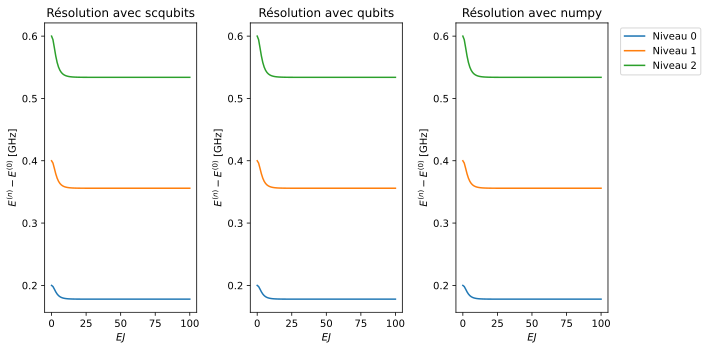

In [57]:
plot_transmon_readout(100)